In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import piqa
import utils
from models import UNet

### Load data

In [152]:
img = utils.load_image('data/set5/butterfly.png')
noisy_img = utils.get_noisy_image(img, 0.1)

### Denoise

In [153]:
epochs = 1800
lr = 0.01
input_channels = 3
deep_channels = [128, 128, 128, 128, 128]
skip_channels = [0, 0, 0, 0, 0]

In [154]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

net = UNet(input_channels, deep_channels, skip_channels)
net.to(device)

optimizer = optim.Adam(net.parameters(), lr)
mse = nn.MSELoss()

noisy_img = noisy_img.to(device)

input_shape = [input_channels if i == 1 else s for i, s in enumerate(noisy_img.size())]
z = torch.rand(input_shape, device=device) * 0.1  # TODO regularize noise?

Training on cuda:0
----------
Epoch  100/1800 | Loss: 0.040892742574214935
Epoch  200/1800 | Loss: 0.031133752316236496
Epoch  300/1800 | Loss: 0.027016710489988327
Epoch  400/1800 | Loss: 0.020363282412290573
Epoch  500/1800 | Loss: 0.018030056729912758
Epoch  600/1800 | Loss: 0.0157169159501791
Epoch  700/1800 | Loss: 0.015708254650235176
Epoch  800/1800 | Loss: 0.015711188316345215
Epoch  900/1800 | Loss: 0.016020340844988823
Epoch 1000/1800 | Loss: 0.012932955287396908
Epoch 1100/1800 | Loss: 0.013017239049077034
Epoch 1200/1800 | Loss: 0.012376099824905396
Epoch 1300/1800 | Loss: 0.012401709333062172
Epoch 1400/1800 | Loss: 0.01195022463798523
Epoch 1500/1800 | Loss: 0.011856045573949814
Epoch 1600/1800 | Loss: 0.011341325007379055
Epoch 1700/1800 | Loss: 0.012913795188069344
Epoch 1800/1800 | Loss: 0.011654912494122982
----------
Finished training in 00:01:02


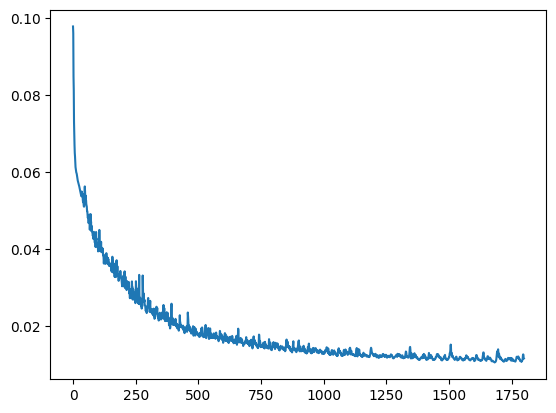

In [155]:
net.train()

print(f'Training on {device}')
print('----------')
start = time.time()

losses = []
for i in range(epochs):
  optimizer.zero_grad()

  out = net(z)
  loss = mse(out, noisy_img)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  if i % 100 == 99:
    print(f'Epoch {i + 1:4d}/{epochs} | Loss: {loss.item()}')

duration = time.time() - start
print('----------')
print(f'Finished training in {time.strftime('%H:%M:%S', time.gmtime(duration))}')

plt.plot(losses)
plt.show()

In [156]:
denoised_img = net(z)

denoised_img = denoised_img.detach().cpu()
noisy_img = noisy_img.cpu()

### Evaluate

In [157]:
psnr = piqa.PSNR()
noisy_psnr = psnr(noisy_img, img).item()
denoised_psnr = psnr(denoised_img, img).item()

print('PSNR (↑)')
print('----------')
print(f'Noisy: {noisy_psnr}')
print(f'Denoised: {denoised_psnr}')

PSNR (↑)
----------
Noisy: 20.308008193969727
Denoised: 25.24806785583496


In [158]:
ssim = piqa.SSIM()
noisy_ssim = ssim(noisy_img, img).item()
denoised_ssim = ssim(denoised_img, img).item()

print('SSIM (↑)')
print('----------')
print(f'Noisy: {noisy_ssim}')
print(f'Denoised: {denoised_ssim}')

SSIM (↑)
----------
Noisy: 0.519874632358551
Denoised: 0.8680554628372192


### Visualize

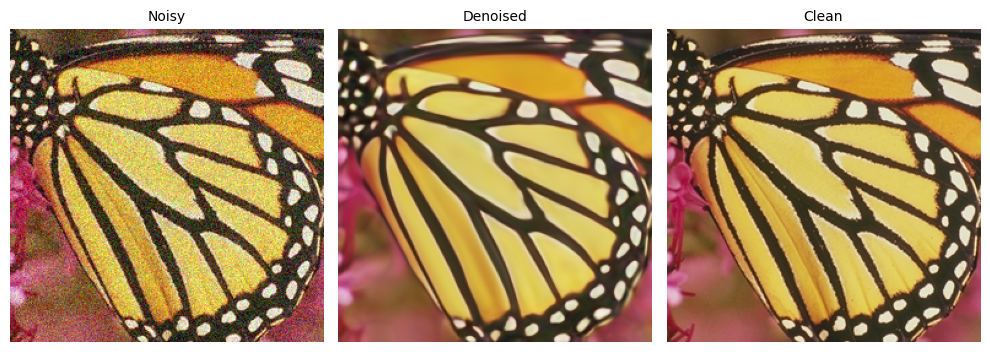

In [159]:
utils.plot_row([noisy_img, denoised_img, img], ['Noisy', 'Denoised', 'Clean'])